# Brain MRI Segmentation

We use [this](https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation/data) dataset.

We initially use a modified version of the original [U-Net](https://arxiv.org/abs/1505.04597) architecture. 

Later on, we might try the [Attention U-Net](https://arxiv.org/abs/1804.03999) architecture.

Note: you will find a lot of functions `fn()`. These functions are just meant to test if the code written is working as it should. I put the testing code inside these functions as I didn't want to waste the namespace.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-segmentation/images/2664.png
/kaggle/input/brain-tumor-segmentation/images/2539.png
/kaggle/input/brain-tumor-segmentation/images/1231.png
/kaggle/input/brain-tumor-segmentation/images/1017.png
/kaggle/input/brain-tumor-segmentation/images/2437.png
/kaggle/input/brain-tumor-segmentation/images/2015.png
/kaggle/input/brain-tumor-segmentation/images/2300.png
/kaggle/input/brain-tumor-segmentation/images/2673.png
/kaggle/input/brain-tumor-segmentation/images/2823.png
/kaggle/input/brain-tumor-segmentation/images/1522.png
/kaggle/input/brain-tumor-segmentation/images/2064.png
/kaggle/input/brain-tumor-segmentation/images/641.png
/kaggle/input/brain-tumor-segmentation/images/1088.png
/kaggle/input/brain-tumor-segmentation/images/173.png
/kaggle/input/brain-tumor-segmentation/images/2851.png
/kaggle/input/brain-tumor-segmentation/images/2448.png
/kaggle/input/brain-tumor-segmentation/images/1746.png
/kaggle/input/brain-tumor-segmentation/images/1958.png
/kaggle/inpu

In [2]:
# %load_ext autoreload
# %autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import torchinfo
from torchinfo import summary

from tqdm import tqdm
import os
import cv2
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
import pytz
from datetime import datetime
import time
import glob
# import joblib
# import albumentations

import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import stats
# import seaborn as sns
# plt.style.use("fivethirtyeight")
# plt.style.use("default")

# import warnings
# warnings.filterwarnings("ignore")

%matplotlib inline
# %config InlineBackend.figure_format="svg"

print("Imports done!")

Imports done!


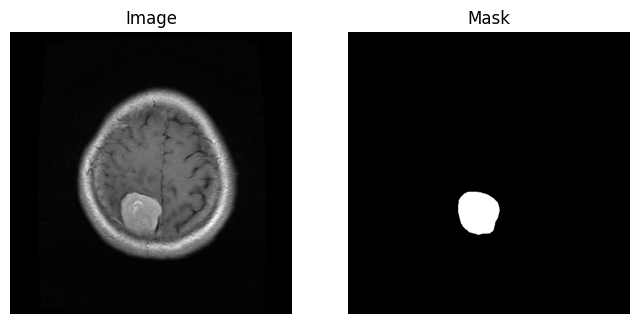

In [3]:
def visualize_data():
    idx = np.random.randint(low=1, high=3064, size=1)[0]
    PATH = "../input/brain-tumor-segmentation/"
    img = plt.imread(PATH+f"images/{idx}.png")
    mask = plt.imread(PATH+f"masks/{idx}.png")
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,5))
    ax[0].imshow(img, cmap="gray")
    ax[0].set_title("Image")
    ax[0].axis("off")
    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title("Mask")
    ax[1].axis("off")
    pass

visualize_data()

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [5]:
image_folder_path = Path('/kaggle/input/brain-tumor-segmentation/images')
mask_folder_path = Path('/kaggle/input/brain-tumor-segmentation/masks')


def check_images_exist():
    """
    Check if all the images from 1 to 3064 exist.
    Returns False if any image is missing else returns True.
    """
    for i in range(1, len(os.listdir(image_folder_path))+1):
        image_path = image_folder_path/f"{i}.png"
        if not image_path.is_file():
            print(image_path)
            return False
    return True


def check_masks_exist():
    """
    Check if all the masks from 1 to 3064 exist.
    Returns False if any mask is missing else returns True.
    """
    for i in range(1, len(os.listdir(mask_folder_path))+1):
        mask_path = mask_folder_path/f"{i}.png"
        if not mask_path.is_file():
            print(mask_path)
            return False
    return True


print("All images from 1 to 3064 exist:", check_images_exist())
print("All masks from 1 to 3064 exist:", check_masks_exist())


All images from 1 to 3064 exist: True
All masks from 1 to 3064 exist: True


In [6]:
def get_data_paths(image_folder_path: str, mask_folder_path: str):
    """
    image_folder: Path of the folder that contains all the images (must be a string)
    mask_folder: Path of the folder that contains all the masks (must be a string)
    
    Returns 2 lists that contains paths of all the images and masks, respectively.
    """
    all_images_path = []
    all_masks_path = []
    for image in glob.glob(image_folder_path+"/*"):
        all_images_path.append(image)
    for mask in glob.glob(mask_folder_path+"/*"):
        all_masks_path.append(mask)
    return all_images_path, all_masks_path


all_images_path, all_masks_path = get_data_paths(str(image_folder_path), str(mask_folder_path))

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(all_images_path, all_masks_path, 
                                                      test_size=0.3, random_state=42, 
                                                      shuffle=True)

In [8]:
print(len(X_train), len(X_valid))
print(len(y_train), len(y_valid))

2144 920
2144 920


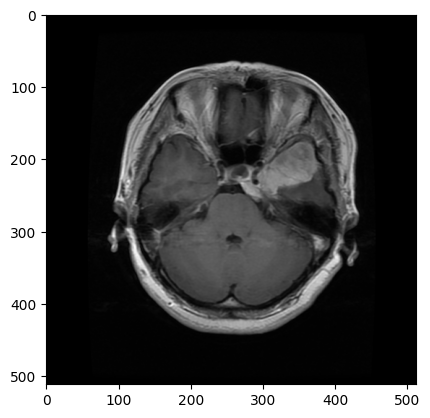

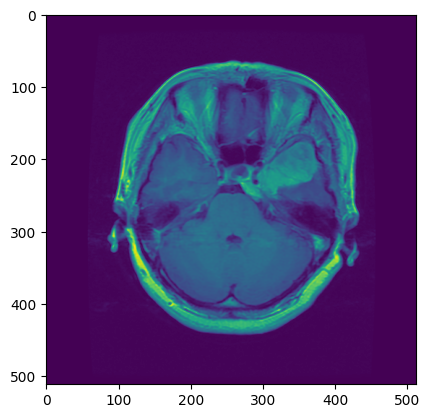

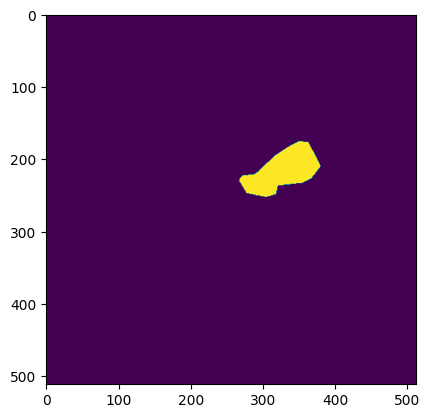

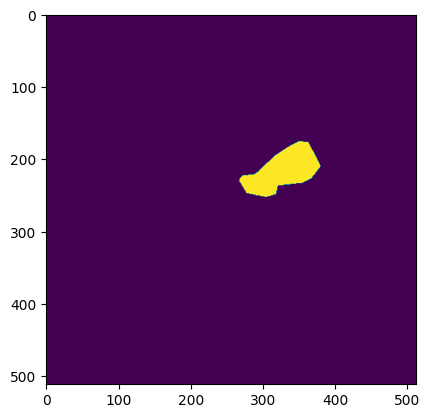

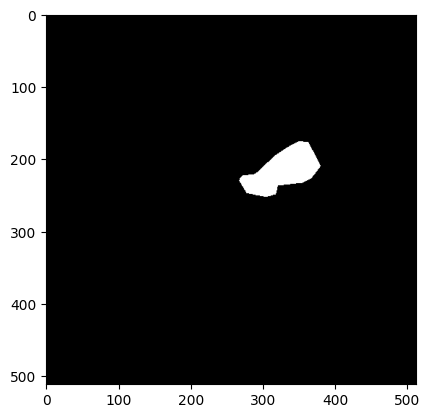

In [9]:
def fn():
    image_path = "/kaggle/input/brain-tumor-segmentation/images/1.png"
    mask_path = "/kaggle/input/brain-tumor-segmentation/masks/1.png"
    image1 = Image.open(image_path).convert("RGB")
    image2 = Image.open(image_path)
    mask1 = Image.open(mask_path).convert("L")
    mask2 = Image.open(mask_path)
    mask3 = Image.open(mask_path).convert("RGB")
    plt.imshow(image1)
    plt.show()
    plt.imshow(image2)
    plt.show()
    plt.imshow(mask1)
    plt.show()
    plt.imshow(mask2)
    plt.show()
    plt.imshow(mask3)
    plt.show()

fn()

In [10]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, mask_paths, augmentations=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        # image = Image.open(image_path)
        image2 = Image.open(image_path).convert("RGB")   # convert the image to RGB image
        mask_path = self.mask_paths[idx]
        # mask = Image.open(mask_path)
        mask2 = Image.open(mask_path).convert("L")   # convert the mask to a grayscale mask
        # the above conversions might result in better performance as without conversions
        # the peak performance was around 0.1 validation loss
        if self.augmentations is not None:
            image = self.augmentations(image2)
            mask = self.augmentations(mask2)
        return image, mask
    

In [11]:
augmentations = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [12]:
train_dataset = CustomDataset(image_paths=X_train, mask_paths=y_train, augmentations=augmentations) 
valid_dataset = CustomDataset(image_paths=X_valid, mask_paths=y_valid, augmentations=augmentations)

In [13]:
train_dataset[0][0].dtype

torch.float32

In [14]:
train_dataset[0][0].shape

torch.Size([3, 256, 256])

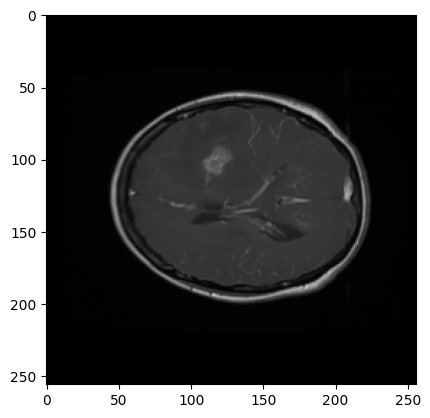

In [15]:
plt.imshow(train_dataset[0][0].numpy().T);

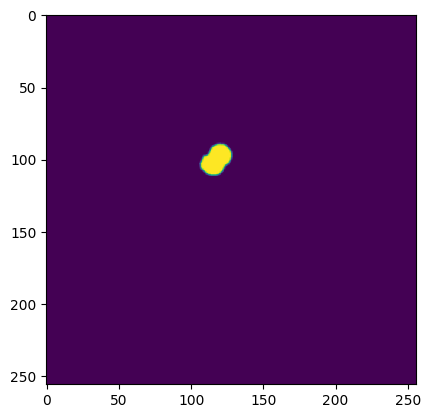

In [16]:
plt.imshow(train_dataset[0][1].numpy().T);

In [17]:

"""Helpful utility functions for PyTorch models."""


def set_dataloaders(batch_size=32):
    train_loader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True)
                              # drop_last=True  # this will drop the last batch if its size is not 32
                              # pin_memory=True,
                              # num_workers=os.cpu_count())
    val_loader = DataLoader(valid_dataset,
                            batch_size=batch_size,
                            shuffle=False)
                            # drop_last=True  # this will drop the last batch if its size is not 32
                            # pin_memory=True,
                            # num_workers=os.cpu_count())
#     test_loader = DataLoader(test_dataset,
#                              batch_size=batch_size,
#                              shuffle=False)
#                              # drop_last=True  # this will drop the last batch if its size is not 32
#                              # pin_memory=True,
#                              # num_workers=os.cpu_count())
    return train_loader, val_loader


def set_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        # if version of pytorch is =< 1.7, then use torch.set_deterministic(True)
        # else use torch.use_deterministic_algorithms(True)
        torch.use_deterministic_algorithms(True)
        
        
def compute_accuracy(y_pred, y):
    assert len(y_pred)==len(y), "length of y_pred and y must be equal"
    acc = torch.eq(y_pred, y).sum().item()
    acc /= len(y_pred)
    return acc
    

def train_step(model, dataloader, loss_fn, optimizer, device):
    """
    Processes just one training step, ie, just one epoch.
    To be used inside the main the training function.
    """
    # initialize the training loss value of this entire batch to 0
    train_loss = 0
    # put the model in training mode
    model.train()
    # loop through the data loader batches
    for X, y in dataloader:
        # send both the X and y to device being used
        # we assume that the model is on this device already
        X = X.to(device)
        y = y.to(device)
        # forward pass
        y_pred = model(X)
        # calculate the loss and add it to the batch's training loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        # zero the gradients of the optimizer so that they don't accumulate
        optimizer.zero_grad()
        # do a backward pass on the loss
        loss.backward()
        # update the optimizer (ie, update the gradients)
        optimizer.step()
    # calculate the average training loss and accuracy for this batch
    train_loss = train_loss/len(dataloader)
    return train_loss


def validation_step(model, dataloader, loss_fn, device):
    """
    Processes just one step of validation, ie, just one batch.
    To be used inside the main training function.
    """
    # initialize the validation loss value of this entire batch to 0
    val_loss = 0
    # put the model to evaluation mode
    model.eval()
    # turn on the inference context manager
    with torch.inference_mode():
        # loop through the dataloader batches
        for X, y in dataloader:
            # send both X and y to the device being used
            # we assume that the model is on this device already
            X = X.to(device)
            y = y.to(device)
            # forward pass
            y_pred = model(X)
            # calculate the loss and add it to the batch's validation loss
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()
    # calculate the average validation loss and accuracy for this batch
    val_loss = val_loss/len(dataloader)
    return val_loss


def set_scheduler(scheduler, results, scheduler_on="val_loss"):
    """Makes the neccessary updates to the scheduler."""
    if scheduler_on == "val_loss":
        scheduler.step(results["val_loss"][-1])
    elif scheduler_on == "train_loss":
        scheduler.step(results["train_loss"][-1])
    else:
        raise ValueError("Invalid `scheduler_on` choice.")
    return scheduler


def training_fn(model, train_loader, val_loader, loss_fn, optimizer, 
                epochs, device, scheduler=None, scheduler_on="val_loss"):
    """The main training function."""
    # create a results dictionary
    results = {
        "train_loss": [],
        "val_loss": []
    }
    # loop through the training and validation steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        # call the training function
        train_loss = train_step(model, train_loader, loss_fn, 
                                optimizer, device)
        # call the validation function
        val_loss = validation_step(model, val_loader, loss_fn, device)
        # update the results dictionary
        results["train_loss"].append(train_loss)
        results["val_loss"].append(val_loss)
        if scheduler is not None:
            # adjust the learning rate
            scheduler = set_scheduler(scheduler, results, scheduler_on)
        # print out what's happening
        print(
            f"Epoch: {epoch+1} | Train_loss: {train_loss:.5f} | "
            f"Val_loss: {val_loss:.5f}"
        )
    return results


def save_model_info(path: str, model, model_name, optimizer, optimizer_name, 
                    scheduler=None, scheduler_name=""):
    # A good practice is to transfer the model to the CPU before calling torch.save as this 
    # will save tensors as CPU tensors and not as CUDA tensors. This will help in loading
    # the model onto any machine, whether it contains CUDA capabilities or not.
    model.to("cpu")
    torch.save(model.state_dict(), os.path.join(path,model_name))
    torch.save(optimizer.state_dict(), os.path.join(path,optimizer_name))
    if scheduler is not None:
        torch.save(scheduler.state_dict(), os.path.join(path,scheduler_name))    
    print("Model info saved!")
    
    
def load_model_info(PATH, device, model, model_name, optimizer, optimizer_name, 
                    scheduler=None, scheduler_name=""):
    model.load_state_dict(torch.load(PATH/model_name))
    model.to(device)
    optimizer.load_state_dict(torch.load(PATH/optimizer_name))
    if scheduler is not None:
        scheduler.load_state_dict(torch.load(PATH/scheduler_name))
    print("Model info loaded!")
    
    
def get_current_time():
    """Returns the current time in Toronto."""
    now = datetime.now(pytz.timezone('Canada/Eastern'))
    current_time = now.strftime("%d_%m_%Y__%H_%M_%S")
    return current_time


def visualize_results(results):
    """Plot the training and validation loss, given the results dictionary"""
    train_loss = results["train_loss"]
    val_loss = results["val_loss"]
    x = np.arange(len(train_loss))  # this is the number of epochs
    plt.figure(figsize=(7,4))
    plt.xlabel("Epochs")
    plt.title("BCE with Logits Loss")
    plt.plot(x, train_loss, label="train_loss", color="orange")
    plt.plot(x, val_loss, label="val_loss", color="blue")
    plt.legend()
    plt.show()    
    
    
def calculate_iou(pred_mask, true_mask, threshold=0.5):
    pred_mask = (pred_mask > threshold).float()
    true_mask = (true_mask > threshold).float()
    intersection = torch.sum(pred_mask * true_mask)
    union = torch.sum((pred_mask + true_mask) > 0)
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.item()


In [18]:
train_loader, val_loader = set_dataloaders(4)

In [19]:
def fn():
    for X, y in train_loader:
        print(X.shape, y.shape, sep='\n')
        break
    pass

fn()

torch.Size([4, 3, 256, 256])
torch.Size([4, 1, 256, 256])


In [20]:
# def fn():
#     model = UNet1().to(DEVICE)
#     img = torch.randn(1,1,572,572).to(DEVICE)  # (N,C,H,W)
#     model(img)
#     output = model(img)
#     print(output.shape)
    
# fn()

In [21]:
# def fn():
#     model = UNet1().to(DEVICE)
#     # image size is 572x572 as described in the original UNet architecture paper
#     return summary(model=model, input_size=(1,1,572,572),
#             col_names=["input_size", "output_size", "num_params", "trainable"],
#             col_width=20, row_settings=["var_names"])
    
# fn()

Let's try a modified version of the [U-Net](https://arxiv.org/abs/1505.04597) architecture.

In [22]:
def double_conv(in_chan, out_chan):
    network = nn.Sequential(
        nn.Conv2d(in_channels=in_chan, out_channels=out_chan, kernel_size=(3,3), 
                  stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_chan),   # added new 
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_chan, out_channels=out_chan, kernel_size=(3,3), 
                  stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_chan),   # added new 
        nn.ReLU(inplace=True)
    )
    return network


def crop_img(original: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    original_size = original.size()[2]
    target_size = target.size()[2]
    idx1 = (original_size - target_size)//2
    idx2 = original_size - idx1
    return original[:, :, idx1:idx2, idx1:idx2]


class UNet1(nn.Module):
    def __init__(self):
        super(UNet1, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.downconv1 = double_conv(1, 64)
        self.downconv2 = double_conv(64, 128)
        self.downconv3 = double_conv(128, 256)
        self.downconv4 = double_conv(256, 512)
        self.downconv5 = double_conv(512, 1024)
        self.trans1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.upconv1 = double_conv(1024, 512)
        self.trans2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv2 = double_conv(512, 256)
        self.trans3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv3 = double_conv(256, 128)
        self.trans4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.upconv4 = double_conv(128, 64)
        self.out = nn.Conv2d(64, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, img):
        # ENCODER
        x1 = self.downconv1(img)
        x2 = self.maxpool(x1)
        x3 = self.downconv2(x2)
        x4 = self.maxpool(x3)
        x5 = self.downconv3(x4)
        x6 = self.maxpool(x5)
        x7 = self.downconv4(x6)
        x8 = self.maxpool(x7)
        x9 = self.downconv5(x8)
        # DECODER
        a = self.trans1(x9)
        b = crop_img(x7, a)
        c = torch.cat([a,b], 1)
        d = self.upconv1(c)
        a = self.trans2(d)
        b = crop_img(x5, a)
        c = torch.cat([a,b], 1)
        d = self.upconv2(c)
        a = self.trans3(d)
        b = crop_img(x3, a)
        c = torch.cat([a,b], 1)
        d = self.upconv3(c)
        a = self.trans4(d)
        b = crop_img(x1, a)
        c = torch.cat([a,b], 1)
        d = self.upconv4(c)
        # we do sigmoid in the end, as we normalized our images and masks and 
        # sigmoid helps us output the model's predicted images in the 0 and 1 range
        out = self.sigmoid(self.out(d))
        return out
    

In [23]:
# Taken from : https://www.kaggle.com/code/marcopatino/u-net-for-mri-brain-tumor-segmentation/notebook

class UNet2(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet2, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(double_conv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(double_conv(feature*2, feature))

        self.bottleneck = double_conv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = transforms.functional.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


In [24]:
def fn():
    model = UNet1().to(DEVICE)
    return summary(model=model, input_size=(1,1,256,256),
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20, row_settings=["var_names"])
    
fn()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
UNet1 (UNet1)                            [1, 1, 256, 256]     [1, 1, 256, 256]     --                   True
├─Sequential (downconv1)                 [1, 1, 256, 256]     [1, 64, 256, 256]    --                   True
│    └─Conv2d (0)                        [1, 1, 256, 256]     [1, 64, 256, 256]    576                  True
│    └─BatchNorm2d (1)                   [1, 64, 256, 256]    [1, 64, 256, 256]    128                  True
│    └─ReLU (2)                          [1, 64, 256, 256]    [1, 64, 256, 256]    --                   --
│    └─Conv2d (3)                        [1, 64, 256, 256]    [1, 64, 256, 256]    36,864               True
│    └─BatchNorm2d (4)                   [1, 64, 256, 256]    [1, 64, 256, 256]    128                  True
│    └─ReLU (5)                          [1, 64, 256, 256]    [1, 64, 256, 256]    --                   --
├─MaxPool2d (maxpo

In [25]:
def fn():
    model = UNet2().to(DEVICE)
    return summary(model=model, input_size=(1,3,256,256),
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20, row_settings=["var_names"])
    
fn()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
UNet2 (UNet2)                            [1, 3, 256, 256]     [1, 1, 256, 256]     --                   True
├─ModuleList (downs)                     --                   --                   (recursive)          True
│    └─Sequential (0)                    [1, 3, 256, 256]     [1, 64, 256, 256]    --                   True
│    │    └─Conv2d (0)                   [1, 3, 256, 256]     [1, 64, 256, 256]    1,728                True
│    │    └─BatchNorm2d (1)              [1, 64, 256, 256]    [1, 64, 256, 256]    128                  True
│    │    └─ReLU (2)                     [1, 64, 256, 256]    [1, 64, 256, 256]    --                   --
│    │    └─Conv2d (3)                   [1, 64, 256, 256]    [1, 64, 256, 256]    36,864               True
│    │    └─BatchNorm2d (4)              [1, 64, 256, 256]    [1, 64, 256, 256]    128                  True
│    │    └─ReLU

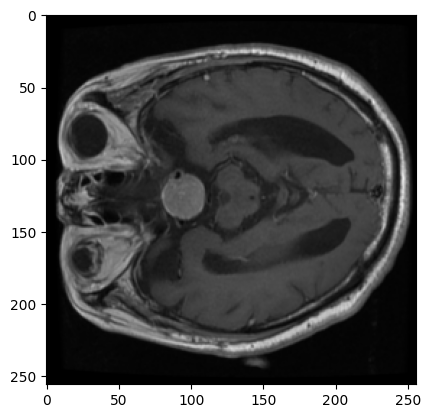

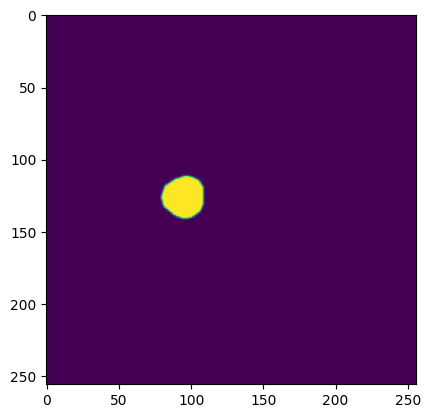

In [26]:
def fn():
    for X, y in train_loader:
        img = X[0].cpu().detach().numpy()
        mask = y[0].cpu().detach().numpy()
        break
    plt.imshow(img.T)
    plt.show()
    plt.imshow(mask.T)
    plt.show()
    pass

fn()

In [27]:
train_loader, val_loader = set_dataloaders(8)
# increasing the batch size more than 8 will result in CUDA out of memory

In [28]:
def fn():
#     model = UNet1().to(DEVICE)
    model = UNet2().to(DEVICE)
    for X,y in train_loader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        print("-------------\t", "torch.Size([ N, C, H,  W])")
        print("Input shape:\t", X.shape)
        pred = model(X)
        print("Output shape:\t", pred.shape)
        print("Target shape:\t", y.shape)
#         iou_loss = calculate_iou(pred, y)
#         print(iou_loss)
        break
    pass
    
fn()

-------------	 torch.Size([ N, C, H,  W])
Input shape:	 torch.Size([8, 3, 256, 256])
Output shape:	 torch.Size([8, 1, 256, 256])
Target shape:	 torch.Size([8, 1, 256, 256])


-------------	 torch.Size([ N, C, H,  W])
Input shape:	 torch.Size([8, 3, 256, 256])
Output shape:	 torch.Size([8, 1, 256, 256])
torch.Size([1, 256, 256])


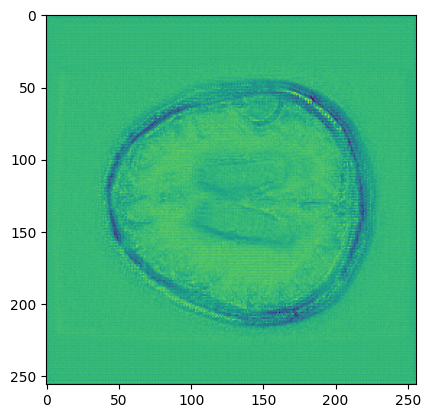

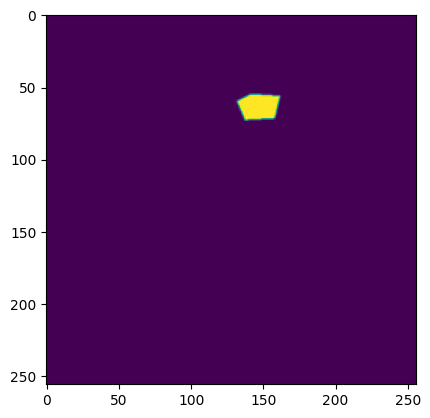

In [29]:
def fn():
#     model = UNet1().to(DEVICE)
    model = UNet2().to(DEVICE)
    for X,y in train_loader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        print("-------------\t", "torch.Size([ N, C, H,  W])")
        print("Input shape:\t", X.shape)
        pred = model(X)
        print("Output shape:\t", pred.shape)
        break
    output = pred[0]
    mask = y[0].cpu().detach().numpy()
    print(output.shape)
    img = output.cpu().detach().numpy()
    plt.imshow(img.T)
    plt.show()
    plt.imshow(mask.T)
    pass
    
fn()

In [30]:
# use this code to free up gpu memory
import gc
gc.collect()
torch.cuda.empty_cache()

In [31]:
train_loader, val_loader = set_dataloaders(8)  
# increasing the batch size more than 8 will result in CUDA out of memory

In [32]:
model1 = UNet1().to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()    # Binary Cross Entropy loss for binary segmentation
optimizer1 = optim.Adam(params=model1.parameters(), lr=0.001)

In [33]:
model2 = UNet2().to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()    # Binary Cross Entropy loss for binary segmentation
optimizer2 = optim.Adam(params=model2.parameters(), lr=0.001)

In [34]:
train_step(model2, train_loader, loss_fn, optimizer2, DEVICE)

0.12466065669015272

If we you encounter an `OutOfMemoryError`, then you can decrease the batch size of the data loaders or you can decrease the size of the images, ie, maybe use `Resize((128,128))` in `transforms.Compose`.

In [35]:
# use this code to free up gpu memory
import gc
gc.collect()
torch.cuda.empty_cache()

In [36]:
results = training_fn(model2, train_loader, val_loader, loss_fn, optimizer2, epochs=30, device=DEVICE)

  3%|▎         | 1/30 [01:26<41:58, 86.86s/it]

Epoch: 1 | Train_loss: 0.05148 | Val_loss: 0.08114


  7%|▋         | 2/30 [02:42<37:29, 80.33s/it]

Epoch: 2 | Train_loss: 0.04205 | Val_loss: 0.04364


 10%|█         | 3/30 [03:58<35:08, 78.08s/it]

Epoch: 3 | Train_loss: 0.03746 | Val_loss: 0.03938


 13%|█▎        | 4/30 [05:13<33:23, 77.06s/it]

Epoch: 4 | Train_loss: 0.03433 | Val_loss: 0.03657


 17%|█▋        | 5/30 [06:29<31:52, 76.49s/it]

Epoch: 5 | Train_loss: 0.03267 | Val_loss: 0.03349


 20%|██        | 6/30 [07:44<30:27, 76.14s/it]

Epoch: 6 | Train_loss: 0.03011 | Val_loss: 0.03088


 23%|██▎       | 7/30 [08:59<29:06, 75.94s/it]

Epoch: 7 | Train_loss: 0.02819 | Val_loss: 0.03713


 27%|██▋       | 8/30 [10:15<27:47, 75.78s/it]

Epoch: 8 | Train_loss: 0.02661 | Val_loss: 0.02785


 30%|███       | 9/30 [11:30<26:29, 75.69s/it]

Epoch: 9 | Train_loss: 0.02419 | Val_loss: 0.02766


 33%|███▎      | 10/30 [12:46<25:14, 75.74s/it]

Epoch: 10 | Train_loss: 0.02299 | Val_loss: 0.06553


 37%|███▋      | 11/30 [14:02<23:58, 75.70s/it]

Epoch: 11 | Train_loss: 0.02077 | Val_loss: 0.03017


 40%|████      | 12/30 [15:18<22:42, 75.70s/it]

Epoch: 12 | Train_loss: 0.01951 | Val_loss: 0.02224


 43%|████▎     | 13/30 [16:33<21:26, 75.68s/it]

Epoch: 13 | Train_loss: 0.01896 | Val_loss: 0.02267


 47%|████▋     | 14/30 [17:49<20:10, 75.68s/it]

Epoch: 14 | Train_loss: 0.01718 | Val_loss: 0.02194


 50%|█████     | 15/30 [19:05<18:55, 75.68s/it]

Epoch: 15 | Train_loss: 0.01566 | Val_loss: 0.02707


 53%|█████▎    | 16/30 [20:20<17:38, 75.59s/it]

Epoch: 16 | Train_loss: 0.01514 | Val_loss: 0.02080


 57%|█████▋    | 17/30 [21:37<16:28, 76.03s/it]

Epoch: 17 | Train_loss: 0.01373 | Val_loss: 0.02224


 60%|██████    | 18/30 [22:53<15:10, 75.91s/it]

Epoch: 18 | Train_loss: 0.01264 | Val_loss: 0.02165


 63%|██████▎   | 19/30 [24:08<13:54, 75.84s/it]

Epoch: 19 | Train_loss: 0.01124 | Val_loss: 0.01992


 67%|██████▋   | 20/30 [25:24<12:37, 75.79s/it]

Epoch: 20 | Train_loss: 0.01131 | Val_loss: 0.02558


 70%|███████   | 21/30 [26:40<11:21, 75.75s/it]

Epoch: 21 | Train_loss: 0.00992 | Val_loss: 0.02433


 73%|███████▎  | 22/30 [27:55<10:05, 75.74s/it]

Epoch: 22 | Train_loss: 0.00931 | Val_loss: 0.02143


 77%|███████▋  | 23/30 [29:11<08:49, 75.64s/it]

Epoch: 23 | Train_loss: 0.00988 | Val_loss: 0.03010


 80%|████████  | 24/30 [30:26<07:33, 75.64s/it]

Epoch: 24 | Train_loss: 0.00922 | Val_loss: 0.02076


 83%|████████▎ | 25/30 [31:42<06:18, 75.69s/it]

Epoch: 25 | Train_loss: 0.00789 | Val_loss: 0.02060


 87%|████████▋ | 26/30 [32:58<05:02, 75.63s/it]

Epoch: 26 | Train_loss: 0.00694 | Val_loss: 0.02265


 90%|█████████ | 27/30 [34:13<03:46, 75.61s/it]

Epoch: 27 | Train_loss: 0.00650 | Val_loss: 0.02390


 93%|█████████▎| 28/30 [35:29<02:31, 75.57s/it]

Epoch: 28 | Train_loss: 0.00645 | Val_loss: 0.02302


 97%|█████████▋| 29/30 [36:44<01:15, 75.59s/it]

Epoch: 29 | Train_loss: 0.00754 | Val_loss: 0.02238


100%|██████████| 30/30 [38:00<00:00, 76.01s/it]

Epoch: 30 | Train_loss: 0.00738 | Val_loss: 0.02400


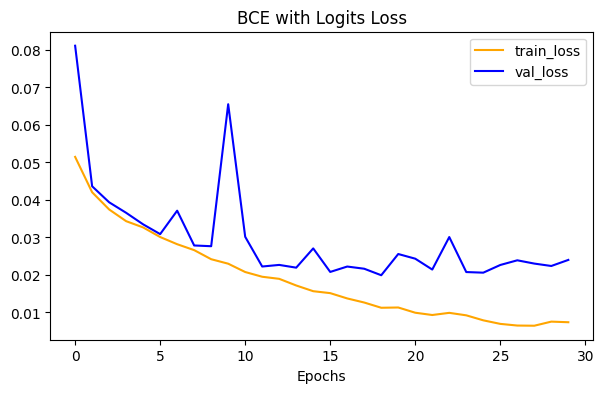

In [37]:
visualize_results(results)

In [38]:
curr_time = get_current_time()
curr_time

'16_03_2024__01_07_31'

In [39]:
PATH = os.getcwd() / Path(curr_time)
PATH.mkdir(parents=True, exist_ok=True)
model_name = "UNet2_1.pt"
optimizer_name = "Adam2_1.pt"
# scheduler_name = "ReduceLROnPlateau.pt"

save_model_info(PATH, DEVICE, model2, model_name, optimizer2, optimizer_name)


Model info saved!


In [40]:
NEW_LEARNING_RATE = optimizer2.param_groups[0]["lr"]

loaded_model1 = UNet2().to(DEVICE)
loaded_optimizer1 = optim.Adam(params=loaded_model1.parameters(), lr=NEW_LEARNING_RATE)
# loaded_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, 
#                                                         mode="max", verbose=True)

load_model_info(PATH, DEVICE, loaded_model1, model_name, loaded_optimizer1, optimizer_name)

Model info loaded!


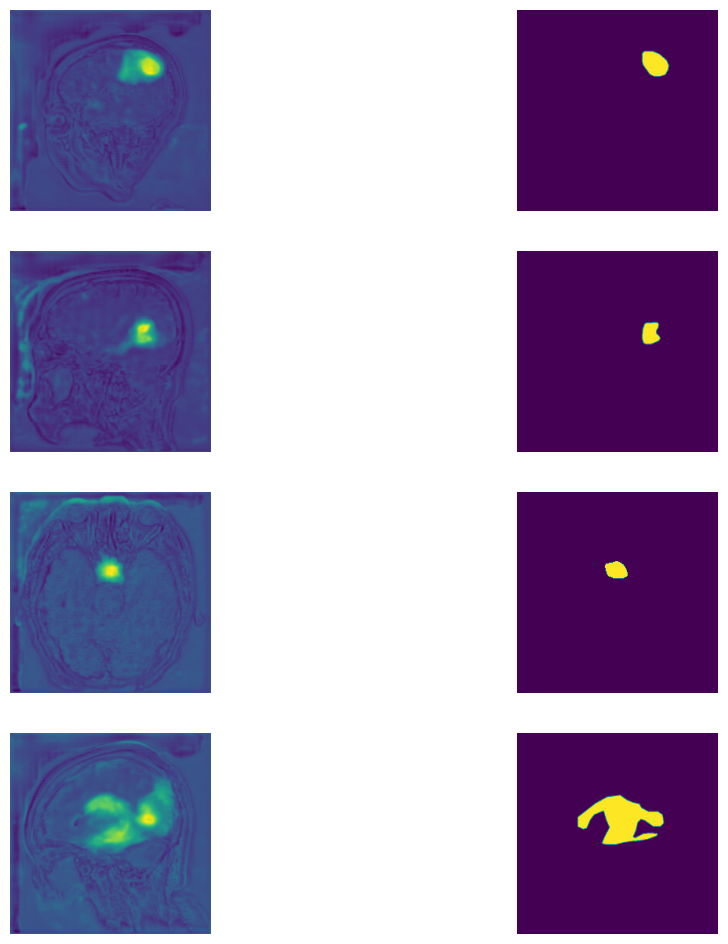

In [41]:
def fn():
    model2.eval()
    with torch.inference_mode():
        for X,y in val_loader:
            X = X.to(DEVICE)
            y = y.to(DEVICE)
            pred = model2(X)
            break
    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,12))
    for i in range(4):
        output = pred[i]
        mask = y[i].cpu().detach().numpy().squeeze(axis=0)
        # print("output.shape:\t", output.shape)
        img = output.cpu().detach().numpy().squeeze(axis=0)
        ax[i,0].imshow(img)
        ax[i,0].axis("off")
        ax[i,1].imshow(mask)
        ax[i,1].axis("off")
    pass
    
fn()

**TODO:** Let's try the [Attention U-Net](https://arxiv.org/abs/1804.03999) architecture.